In [96]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sp
import matplotlib.image as mpimg
import os
from glob import glob
from PIL import Image
import random


In [97]:
"""
This function is untouched.

# import the image and extract
def imageGenerator(imageVector):
    cleanImage = np.zeros([len(imageVector)-1,len(imageVector)-1])
    for i in range(len(imageVector)-1):
        for j in range(len(imageVector)-1):
            if (imageVector[i][j] > 1):
                cleanImage[i][j] = 1
            else:
                cleanImage[i][j] = -1
    noisyImage = cleanImage + np.random.normal(0, 2, [len(image)-1,len(image)-1])

    for i in range(len(image)-1):
        for j in range(len(image)-1):
            if (noisyImage[i][j] >= 0):
                noisyImage[i][j] = 1
            else:
                noisyImage[i][j] = -1

    return cleanImage,noisyImage
"""

def imageGenerator(imageVector):
    # Normalize to [0, 1] if pixel values are 0–255
    imageVector = imageVector.astype(float)
    imageVector /= np.max(imageVector)
    
    # Create ±1 clean image
    cleanImage = np.where(imageVector > 0.5, 1, -1)
    
    # Add mild Gaussian noise
    noisyImage = cleanImage + np.random.normal(0, 0.2, cleanImage.shape)
    
    # Threshold back to ±1
    noisyImage = np.where(noisyImage >= 0, 1, -1)
    
    return cleanImage, noisyImage

In [98]:
"""
Hopfield training rule.
Before: 

# Building up the coefficient matrix
def trainer(vector,oldCoefMat):
    vector = vector.flatten()
    coefMat = np.zeros([len(vector)-1,len(vector)-1])
    if (np.isscalar(oldCoefMat)):
        for i in range(len(vector)-1):
            for j in range(len(vector)-1):
                if (i!=(i-j)):
                    coefMat[i][i-j] = vector[i]*vector[i-j]
    if (np.shape(oldCoefMat) == np.shape(coefMat)):
        for i in range(len(vector)-1):
            for j in range(len(vector)-1):
                if (i!=(i-j)):
                    coefMat[i][i-j] = vector[i]*vector[i-j]
        coefMat = coefMat + oldCoefMat

    vector = np.reshape(vector, [int(np.sqrt(len(vector))),int(np.sqrt(len(vector)))])
    return coefMat
"""

# AI
def trainer(vector, oldCoefMat):
    vector = vector.flatten()
    N = len(vector)
    
    # Create NxN matrix, not (N-1)x(N-1)
    coefMat = np.zeros((N, N))
    
    # Hebbian learning rule: W_ij = x_i * x_j, i ≠ j
    for i in range(N):
        for j in range(N):
            if i != j:
                coefMat[i, j] = vector[i] * vector[j]
    
    # If this is the first image, return coefMat
    if np.isscalar(oldCoefMat):
        return coefMat
    else:
        # Add to previous learned weights
        return oldCoefMat + coefMat


In [99]:
"""
Prediction function before: 
def prediction(curuptedVec,coefMat):
    curuptedVec = curuptedVec.flatten()
    predictVec = np.zeros(len(curuptedVec))
    for i in range(len(curuptedVec)-1):
        temp = 0
        for j in range(len(curuptedVec)-1):
             temp += coefMat[i][j] * curuptedVec[j]
        if (temp>0):
            predictVec[i] = 1
        if (temp<0):
            predictVec[i] = -1

    predictVec = np.reshape(predictVec, [int(np.sqrt(len(predictVec))),int(np.sqrt(len(predictVec)))])
    return predictVec

"""

# After with the help of AI.

# --- Hopfield recall ---
def prediction(corruptedVec, coefMat):
    corruptedVec = corruptedVec.flatten()
    predictVec = np.zeros(len(corruptedVec))
    
    for i in range(len(corruptedVec) - 1):
        temp = 0
        for j in range(len(corruptedVec)-1):
             temp += coefMat[i][j] * corruptedVec[j]
        if (temp>0):
            predictVec[i] = 1
        if (temp<0):
            predictVec[i] = -1
    
    predictVec = np.reshape(predictVec, [int(np.sqrt(len(predictVec))),int(np.sqrt(len(predictVec)))])
    return predictVec

In [100]:
def load_images_from_folder(folder, image_size=(128, 128)):
    image_paths = []
    for ext in ('*.png', '*.jpg', '*.jpeg'):
        image_paths.extend(glob(os.path.join(folder, '**', ext), recursive=True))

    images = []
    for path in image_paths:
        img = Image.open(path).convert('L')  # convert to grayscale
        img = img.resize(image_size)         # proper rescaling
        img = np.array(img, dtype=float) / 255.0  # normalize to [0,1]
        images.append(img)
    
    print(f"Loaded {len(images)} images from {folder}")
    return images

Loaded 557 images from data/train
Loaded 140 images from data/test


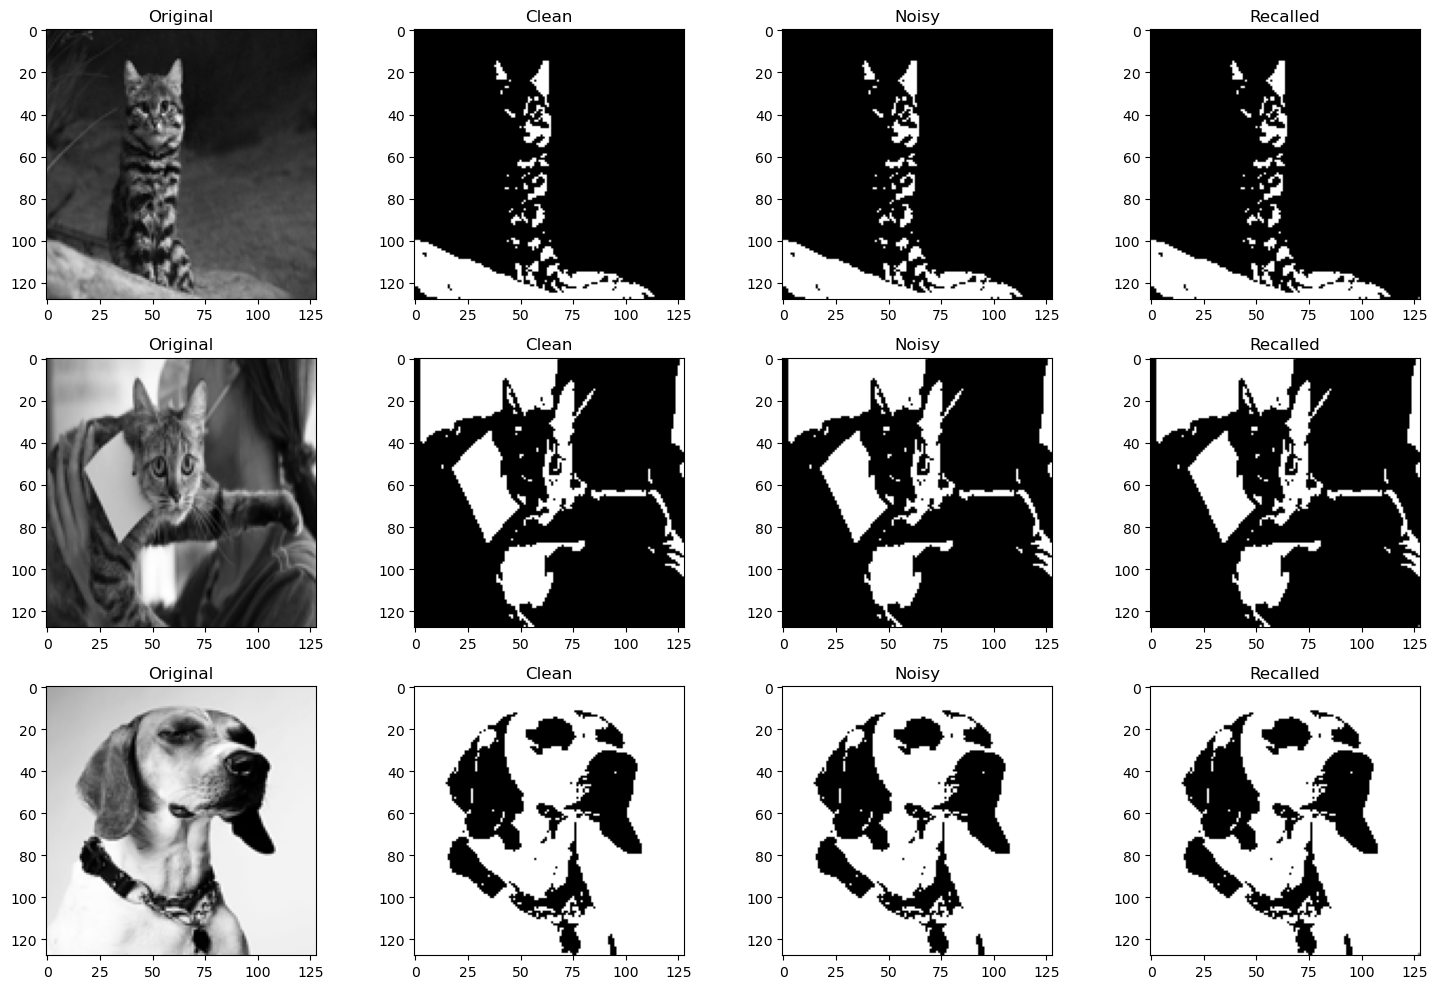

In [101]:
# --- Main ---
train_dir = "data/train"
test_dir = "data/test"

train_images = load_images_from_folder(train_dir)
test_images = load_images_from_folder(test_dir)
# print(test_images)

plt.figure(figsize=(15, 10))
coefMatrix = 0

# Pick 3 random images
selected_images = random.sample(train_images, 3)

for i, image in enumerate(selected_images):
    if (i==1):
        vector,noisyVec = imageGenerator(image)
        coefMatrix = trainer(vector,0)
        predictedVec = prediction(noisyVec,coefMatrix)
    else:
        vector,noisyVec = imageGenerator(image)
        coefMatrix = trainer(vector,coefMatrix)
        predictedVec = prediction(noisyVec,coefMatrix)


    plt.subplot(len(train_images[:3]), 4, 4*i + 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original')

    plt.subplot(len(train_images[:3]), 4, 4*i + 2)
    plt.imshow(vector, cmap='gray')
    plt.title('Clean')

    plt.subplot(len(train_images[:3]), 4, 4*i + 3)
    plt.imshow(noisyVec, cmap='gray')
    plt.title('Noisy')

    plt.subplot(len(train_images[:3]), 4, 4*i + 4)
    plt.imshow(predictedVec, cmap='gray')
    plt.title('Recalled')

plt.tight_layout()
plt.savefig('hopfield_results.png')
plt.show()

In [102]:

""" 

#Import the images
plt.figure(figsize=(15,10))
for i in range(1,4):
    image = img.imread('dataset/pgms/{}.png'.format(i),'w').copy()
    if (i==1):
        vector,noisyVec = imageGenerator(image)
        coefMatrix = trainer(vector,0)
        predictedVec = prediction(noisyVec,coefMatrix)
    else:
        vector,noisyVec = imageGenerator(image)
        coefMatrix = trainer(vector,coefMatrix)
        predictedVec = prediction(noisyVec,coefMatrix)

    plt.subplot(i,4,1)
    plt.imshow(image)
    plt.title('Imported Picture 1')
    plt.subplot(i,4,2)
    plt.imshow(vector);
    plt.title('Cleaned and Squared Picture 1')
    plt.subplot(i,4,3)
    plt.imshow(noisyVec);
    plt.title('Noisy Picture 1')
    plt.subplot(i,4,4)
    plt.imshow(predictedVec);
    plt.title('Recalled Picture 1')

plt.savefig('hopfields.png')
plt.clf()
plt.imshow(coefMatrix)
plt.savefig('matrix.png')
plt.title('Coefficient Matrix')
plt.show()



"""

" \n\n#Import the images\nplt.figure(figsize=(15,10))\nfor i in range(1,4):\n    image = img.imread('dataset/pgms/{}.png'.format(i),'w').copy()\n    if (i==1):\n        vector,noisyVec = imageGenerator(image)\n        coefMatrix = trainer(vector,0)\n        predictedVec = prediction(noisyVec,coefMatrix)\n    else:\n        vector,noisyVec = imageGenerator(image)\n        coefMatrix = trainer(vector,coefMatrix)\n        predictedVec = prediction(noisyVec,coefMatrix)\n\n    plt.subplot(i,4,1)\n    plt.imshow(image)\n    plt.title('Imported Picture 1')\n    plt.subplot(i,4,2)\n    plt.imshow(vector);\n    plt.title('Cleaned and Squared Picture 1')\n    plt.subplot(i,4,3)\n    plt.imshow(noisyVec);\n    plt.title('Noisy Picture 1')\n    plt.subplot(i,4,4)\n    plt.imshow(predictedVec);\n    plt.title('Recalled Picture 1')\n\nplt.savefig('hopfields.png')\nplt.clf()\nplt.imshow(coefMatrix)\nplt.savefig('matrix.png')\nplt.title('Coefficient Matrix')\nplt.show()\n\n\n\n"